In [ ]:
%load_ext autoreload
%autoreload 2

## M day normalized mean

$ R_t^{(M)} = \frac{1}{\sqrt{M}} \sum_{k=1}^{M} R_{t+1-k} $

We will first propose a strategy: 

$ S_{t+1} = \beta_{1} R_{t}^{(5)} + \beta_{2} R_{t-20}^{(230)} $

we will first fit beta with various models

In [89]:
import os 
if 'notebooks' in os.getcwd():
    os.chdir('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from src.metrics.custom_metric_QRT_22_6BhdSkn import metric, \
    transform_submission_to_ypred

from src.metrics.benchmark import get_benchmark
from src.linalg.gram_schmidt import gram_schmidt
from src.GD.gradient import gradient
from src.GD.gradient_descent import gradient_descent
from src.metrics.objective_function import objective

In [ ]:
X_train = pd.read_csv('data/X_train_YG7NZSq.csv', index_col=0)
X_train.columns.name = 'date'

In [ ]:
Y_train = pd.read_csv('data/Y_train_wz11VM6.csv', index_col=0)
Y_train.columns.name = 'date'

In [ ]:
X_train_reshape = pd\
    .concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], 1)\
    .dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')

In [ ]:
first_company_mask = X_train_reshape\
    .index\
    .get_level_values("stocksID") == 0

X_train_reshape[first_company_mask]

### Selected Features

In [180]:
# Step 1: Create a 250x10 matrix A with the two first columns representing the factors of interest

A = np.zeros((250,10))

A[0:5, 2] = 1/np.sqrt(5) # 5-day return factor
A[20:250, 1] = 1/np.sqrt(230) # momentum factor
A[0, 0] = 1 # autoregressive factor
# A[0:10, 2] = 1/np.sqrt(10)
# A[0:20, 3] = 1/np.sqrt(20)
# A[0:50, 4] = 1/np.sqrt(50)
# A[0:100, 5] = 1/np.sqrt(100)
# A[150:250, 6] = 1/np.sqrt(100) # momentum factor

A_remaining_columns = np.random.randn(250, 7) # sample random vectors in the space orthogonal to the first two columns of A
A_remaining_columns = np.linalg.qr(A_remaining_columns)[0] # orthonormalize these vectors with Gram-Schmidt algorithm
A[:, 3:] = A_remaining_columns

In [181]:
orthonorm_A = gram_schmidt(A)

In [182]:
pd.DataFrame(orthonorm_A[:,:7]).head(10)

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.5,-0.006476,-0.053900,0.151791,-0.000879
2,0.0,0.0,0.5,0.071950,0.054984,-0.115677,-0.035558
3,0.0,0.0,0.5,-0.090766,0.053951,-0.049721,-0.042831
4,0.0,0.0,0.5,0.025292,-0.055035,0.013607,0.079268
5,0.0,0.0,0.0,-0.019927,0.012196,0.005950,-0.024831
6,0.0,0.0,0.0,-0.020760,-0.035597,-0.061883,0.093203
7,0.0,0.0,0.0,0.023031,0.022282,-0.033533,-0.005924
8,0.0,0.0,0.0,0.001705,0.027022,-0.069368,-0.025259
9,0.0,0.0,0.0,-0.036675,-0.039959,0.005145,-0.021980


In [236]:
features_df = X_train_reshape @ A
target_df = Y_train.T.stack()

In [237]:
features_df

0         1         2         3         4         5  \
date stocksID                                                               
250  0         0.000103  0.012387  0.011243  0.002595 -0.008509 -0.002711   
     1        -0.000982  0.003932  0.000050  0.001616 -0.003902 -0.001686   
     2         0.009301  0.003914  0.004995  0.001539  0.001452  0.002809   
     3         0.006515 -0.006553  0.009464  0.005204  0.004227 -0.005438   
     4        -0.006223  0.005415  0.014643  0.005195  0.004489  0.002695   
...                 ...       ...       ...       ...       ...       ...   
753  45        0.009786 -0.001861  0.012294 -0.023981  0.004069  0.000148   
     46       -0.008842  0.003698  0.005138 -0.004295 -0.010509  0.010230   
     47       -0.008607  0.006122 -0.007828 -0.008224  0.011357 -0.012855   
     48       -0.007519  0.001956  0.001903  0.001535  0.000695  0.004107   
     49       -0.002816 -0.002696 -0.007145 -0.001814  0.004331  0.005457   

                      6         7         8         9  
date stocksID                                          
250  0         0.008934  0.006571 -0.018546 -0.008353  
     1         0.008810  0.001585 -0.000745 -0.002155  
     2         0.005177 -0.006942 -0.013340 -0.008071  
     3         0.008861  0.004025 -0.012432 -0.006100  
     4         0.007609  0.011437 -0.004804  0.039274  
...                 ...       ...       ...       ...  
753  45       -0.062300  0.040002 -0.003475 -0.016284  
     46        0.006846  0.017514 -0.010796 -0.026356  
     47        0.000346 -0.016681  0.008247 -0.002723  
     48       -0.011879  0.000526  0.003178 -0.010654  
     49        0.000633 -0.005819  0.007592 -0.002003  

[25200 rows x 10 columns]

In [111]:
first_company_mask = features_df\
    .index\
    .get_level_values('stocksID') == 0

features_df[first_company_mask]

,,0,1,2,3,4,5,6
date,stocksID,,,,,,,
250,0,0.007969,0.010945,-0.006308,-0.020550,-0.006268,0.000834,-0.002792
251,0,0.012278,0.011471,-0.006378,-0.019819,-0.006099,-0.003268,-0.001942
252,0,0.010650,0.011916,0.003077,-0.023705,-0.010878,-0.005697,-0.004328
253,0,0.002480,0.013004,0.005166,-0.023438,-0.005984,-0.010884,-0.005029
254,0,-0.007423,0.014245,0.006710,-0.021288,-0.004225,-0.012605,-0.005713
...,...,...,...,...,...,...,...,...
749,0,0.003308,-0.014903,-0.003143,0.008094,-0.003172,-0.017630,-0.005685
750,0,0.008357,-0.014173,-0.005247,0.004757,-0.004728,-0.018561,-0.005655
751,0,0.012375,-0.012450,-0.008384,-0.006607,0.003050,-0.018564,-0.003904


In [110]:
target_df[first_company_mask]

date  stocksID
250   0           0.001128
251   0          -0.001046
252   0          -0.007027
253   0          -0.009757
254   0          -0.005868
                    ...   
749   0          -0.001236
750   0          -0.002732
751   0           0.013074
752   0          -0.005843
753   0          -0.003823
Length: 504, dtype: float64

In [112]:
(target_df.index == features_df.index).all()

True

## Machine learning models 

In [ ]:
from sklearn.linear_model import Lasso, Ridge

In [242]:
model = LinearRegression(positive= False)
model = Lasso(alpha = 0.5)
model = Ridge(alpha=0.5)


In [243]:
model.fit(features_df, target_df,)

Ridge(alpha=0.5)

In [244]:
model.coef_

array([ 0.0054892 , -0.00465273, -0.01815817, -0.00329118,  0.0078072 ,
        0.00417895,  0.01177868,  0.00170086, -0.00073056,  0.0080267 ])

In [ ]:
beta = np.zeros(10)

In [ ]:
for i in range(len(model.coef_)):
    beta[i] = model.coef_[i]

beta 

In [245]:
df_A_beta = np.hstack( (np.hstack([A.T, model.coef_.reshape((10, 1))])).T )

In [ ]:
pd.DataFrame(df_A_beta)

In [246]:
y_pred = transform_submission_to_ypred(A, model.coef_, X_train, Y_train)

c:\Users\User\Desktop\code\qrt-2022-challenge\src\metrics\custom_metric_QRT_22_6BhdSkn.py:33: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  X_test_reshape = pd.concat([x_test.shift(i+1).stack(dropna=False) for i in range(250)], 1).dropna()


In [247]:
metric(Y_train, y_pred)

0.023991241721916873

# Gradient descent with Metric function

In [257]:
A = np.eye(250, 10)
A[9,9] = 0
A[20:250, 9] = 1/np.sqrt(230)

In [258]:
beta= np.random.random(10)
# beta[3:] = 0

In [232]:
beta

array([ 0.63046069,  1.37585579, -0.59188007, -0.76110471, -0.3019122 ,
        0.01591263, -0.7093451 ,  0.44388692,  0.38745574, -0.72066007])

In [259]:
k = 0
N_ITER = 1000
beta_new = np.ones(10)
condition = True
convergence = []
while k<N_ITER and condition:
    beta_new = gradient_descent(
        A, 
        beta,
        X_train, 
        Y_train,
        objective, 
        X_train_reshape, 
        alpha=1
    )

    f_k = objective(
        A, 
        beta, 
        X_train, 
        Y_train, 
        X_train_reshape
    )

    if k<=2 : 
        condition = True
    else:
        condition = abs(convergence[-1] - convergence[-2]) > 1e-8
        print(convergence[-1], abs(convergence[-1] - convergence[-2]), k)
    beta = beta_new
    k+=1
    
    convergence.append(f_k)

0.007913816312692072 0.00024848475694356185 3
0.008160553488394982 0.00024673717570290916 4
0.008405553128884849 0.00024499964048986696 5
0.00864882093874813 0.00024326780986328074 6
0.008890358912507598 0.0002415379737594689 7
0.009130166034030586 0.00023980712152298772 8
0.009368239023379394 0.00023807298934880837 9
0.009604573104329038 0.00023633408094964406 10
0.009839162769242767 0.00023458966491372857 11
0.010072002517733514 0.00023283974849074712 12
0.010303087548582494 0.00023108503084898029 13
0.01053241438816775 0.00022932683958525567 14
0.010759981439873431 0.0002275670517056811 15
0.010985789445607594 0.00022580800573416236 16
0.01120984185297129 0.00022405240736369722 17
0.011432145084762063 0.00022230323179077242 18
0.011652708714418494 0.00022056362965643117 19
0.011871545548037231 0.00021883683361873657 20
0.012088671623237398 0.00021712607520016705 21
0.012304106131909002 0.00021543450867160356 22
0.012517871276645451 0.0002137651447364497 23
0.012729992073332058 0.000

KeyboardInterrupt: 

In [249]:
beta

array([ 0.64202813,  0.43944797, -1.22506073, -0.86270735,  0.63967536,
        0.50354093,  0.2870637 , -0.34163848,  0.41897517,  0.90446676])

In [251]:
objective(A, beta, X_train, Y_train, X_train_reshape)

0.03200299676055291

Text(0.5, 0, 'iter')

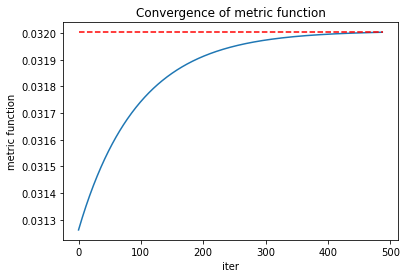

In [252]:
plt.plot(convergence,)
plt.hlines(
    convergence[-1], 
    xmin = 0,
    xmax =len(convergence),
    colors = 'r',
    linestyles= 'dashed', 
)
plt.title("Convergence of metric function")
plt.ylabel("metric function")
plt.xlabel("iter")

In [253]:
df_A_beta = np.hstack( (np.hstack([A.T, beta.reshape((10, 1))])).T )

In [254]:
pd.Series(df_A_beta).to_csv("data/submission.csv")

In [255]:
y_pred = transform_submission_to_ypred(
    A,
    beta, 
    X_train, 
    Y_train
)

c:\Users\User\Desktop\code\qrt-2022-challenge\src\metrics\custom_metric_QRT_22_6BhdSkn.py:33: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  X_test_reshape = pd.concat([x_test.shift(i+1).stack(dropna=False) for i in range(250)], 1).dropna()


In [256]:
metric(Y_train, y_pred)

0.03200299676055291

In [ ]:
get_benchmark(X_train, Y_train)